### Νικόλαος Μανιάτης   
#### Α.Μ.: 03400097

<h1><b>Restricted Boltzmann Machine</b></h1>
<p align="justify">Στην συγκεκριμένη άσκηση θα μελετήσετε τον τρόπο λειτουργίας μιας <i>RBM (<a href="https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine">Restricted Boltzmann Machine</a>)</i>, χρησιμοποιώντας το έτοιμο πρόγραμμα που σας δίνεται.Το συγκεκριμένο πρόγραμμα αξιοποιεί το <a href="https://en.wikipedia.org/wiki/MNIST_database">dataset του <i>MNIST</i></a>, όπου είναι μια μεγάλη βάση δεδομένων με χειρόγραφα ψηφία που χρησιμοποιείται συνήθως για την εκπαίδευση διαφόρων συστημάτων επεξεργασίας εικόνας.</p>
<p align="justify">Μία αρκετά σημαντική εφαρμογή της <i>RBM</i> είναι η εξαγωγή χαρακτηριστικών (feature representation) από ένα dataset με σκοπό την αναπαράσταση της εισόδου (ορατοί νευρώνες) με ένα διάνυσμα μικρότερης διάστασης (κρυφοί νευρώνες). Στη συγκεκριμένη άσκηση θα συγκρίνετε την ακρίβεια ενός ταξινομητή ψηφίων με τη χρήση του αλγορίθμου <i>Logistic Regression</i>, όταν εκείνος δέχεται ως είσοδο το dataset (i) αφου υποστεί επεξεργασία από το <i>RBM</i> και (ii) χωρίς να έχει υποστεί επεξεργασία από το <i>RBM</i>.</p>
<p align="justify">Το δοθέν <i>dataset</i>, στα πλαίσια της άσκησης έχει
διογκωθεί με τεχνητό τρόπο (γραμμική μετατόπιση ενός εικονοστοιχείου (pixel) σε
κάθε κατεύθυνση) ώστε να έχουμε ένα <i>dataset</i> 5 φορές μεγαλύτερο. Με βάση τον κώδικα που σας έχει δοθεί, καλείστε να απαντήσετε στα παρακάτω ερωτήματα:</p>
<ul>
<li>Να περιγράψετε σύντομα τον τρόπο λειτουργίας μιας <i>RBM</i>. Τι διαφορές έχει σε σχέση με μία <i> Μηχανή Boltzmann</i>;</li>
<li>Να αναφέρετε τις βασικότερες εφαρμογές μιας RBM.</li>
<li>Συγκρίνετε τα αποτελέσματα της ταξινόμησης με τον αλγόριθμo <i>Logistic Regression</i> χωρίς τη χρήση RBM σε σχέση με τα αποτελέσματα της ταξινόμησης που έχει χρησιμοποιηθεί η <i>RBM</i> για την εξαγωγή των χαρακτηριστικών. Τι παρατηρείτε ως προς την ακρίβεια των αποτελεσμάτων;</li>
<li>Επιχειρήστε να αλλάξετε τον αριθμό των κρυφών νευρώνων (components) από 100 σε 200. Τι
παρατηρείτε ως προς τα αποτελέσματα και τον χρόνο που έτρεξε το
πρόγραμμα μέχρι να γίνει <i>fit</i>΄;</li>
<li>Προσπαθήστε να τρέξετε το πρόγραμμα τρέξτε το πρόγραμμα εκ νέου με το <i>κανονικό dataset</i>. Τι παρατηρείτε ως προς την ακρίβεια των αποτελεσμάτων; Πού μπορεί να οφείλονται τυχόν αποκλίσεις σε σχέση με πριν;</li>
</ul>

In [2]:
from __future__ import print_function

print(__doc__)

# Authors: Yann N. Dauphin, Vlad Niculae, Gabriel Synnaeve
# License: BSD

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone

Automatically created module for IPython interactive environment


In [3]:
# #############################################################################
# Setting up
def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    def shift(x, w):
        return convolve(x.reshape((8, 8)), mode='constant', weights=w).ravel()

    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y

In [4]:
def load_data(augment=True):
    # Load Data
    digits = datasets.load_digits()
    X = np.asarray(digits.data, 'float32')
    Y = np.asarray(digits.target, 'float32')
    if augment:
        X, Y = nudge_dataset(X, Y)
    X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=0)
    return X_train, X_test, Y_train, Y_test

In [5]:
def train(X_train,Y_train,components=100):
    # Models we will use
    logistic = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000,
                                               multi_class='multinomial')
    rbm = BernoulliRBM(random_state=0, verbose=True)

    rbm_features_classifier = Pipeline(
        steps=[('rbm', rbm), ('logistic', logistic)])

    # #############################################################################
    # Training

    # Hyper-parameters. These were set by cross-validation,
    # using a GridSearchCV. Here we are not performing cross-validation to
    # save time.
    rbm.learning_rate = 0.06
    rbm.n_iter = 20
    # More components tend to give better prediction performance, but larger
    # fitting time
    rbm.n_components = components
    logistic.C = 6000

    # Training RBM-Logistic Pipeline
    rbm_features_classifier.fit(X_train, Y_train)

    # Training the Logistic regression classifier directly on the pixel
    raw_pixel_classifier = clone(logistic)
    raw_pixel_classifier.C = 100.
    raw_pixel_classifier.fit(X_train, Y_train)
    return rbm_features_classifier, raw_pixel_classifier, rbm

In [6]:
# #############################################################################
# Evaluation
def evaluation(X_test,Y_test,rbm_features_classifier, raw_pixel_classifier):
    Y_pred = rbm_features_classifier.predict(X_test)
    print("Logistic regression using RBM features:\n%s\n" % (
        metrics.classification_report(Y_test, Y_pred)))

    Y_pred = raw_pixel_classifier.predict(X_test)
    print("Logistic regression using raw pixel features:\n%s\n" % (
        metrics.classification_report(Y_test, Y_pred)))


In [7]:
# #############################################################################
# Plotting
def plot_features(rbm):
    plt.figure(figsize=(4.2, 4))
    for i, comp in enumerate(rbm.components_):
        plt.subplot(10, 10, i + 1)
        plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r,
                   interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
    plt.suptitle('100 components extracted by RBM', fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

    plt.show()

In [8]:
X_train, X_test, Y_train, Y_test = load_data(augment=True)

In [14]:
%%time
rbm_features_classifier, raw_pixel_classifier, rbm = train(X_train,Y_train,components=100)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.39, time = 0.10s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -23.77, time = 0.20s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -22.94, time = 0.22s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -21.87, time = 0.20s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -21.69, time = 0.20s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -21.09, time = 0.20s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -21.13, time = 0.20s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -20.58, time = 0.21s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20.52, time = 0.20s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -20.17, time = 0.21s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -20.07, time = 0.20s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -19.82, time = 0.20s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -19.55, time = 0.20s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -19.67, time = 0.20s
[BernoulliRBM] Iteration 15, 

In [15]:
evaluation(X_test,Y_test,rbm_features_classifier, raw_pixel_classifier)

Logistic regression using RBM features:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       174
         1.0       0.95      0.91      0.93       184
         2.0       0.92      0.96      0.94       166
         3.0       0.95      0.92      0.94       194
         4.0       0.97      0.95      0.96       186
         5.0       0.92      0.92      0.92       181
         6.0       0.97      0.97      0.97       207
         7.0       0.94      0.99      0.96       154
         8.0       0.90      0.88      0.89       182
         9.0       0.90      0.92      0.91       169

    accuracy                           0.94      1797
   macro avg       0.94      0.94      0.94      1797
weighted avg       0.94      0.94      0.94      1797


Logistic regression using raw pixel features:
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91       174
         1.0       0.60      0.59      0.59  

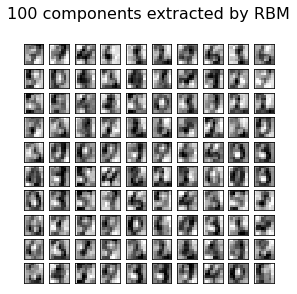

In [23]:
plot_features(rbm)

 - > Να περιγράψετε σύντομα τον τρόπο λειτουργίας μιας RBM. Τι διαφορές έχει σε σχέση με μία Μηχανή Boltzmann;  
 
Μια Restricted Boltzmann Machine είναι ένα παραγωγικό στοχαστικό νευρωνικό δίκτυο το οποίο μπορεί να ανακαλύψει features ανάλογα με το input που του δίνεται. Αποτελείται από δύο ειδών επίπεδα (layers), ορατά (visible) και κρυφά (hidden). Τα επίπεδα μεταξύ τους είναι fully connected δηλαδή συνδέονται, όμως νευρώνες ίδιου επιπέδου δεν συνδέονται μεταξύ τους. Κάθε νευρώνας παίρνει binary τιμές (0 ή 1). Σε λίγα λόγια, η διαδικασία της μάθησης ξεκινάει με την είσοδο των inputs στους ορατούς νευρώνες και μέσω gradient ascent προσδιορίζονται τα βάρη των νευρώνων όλων των επιπέδων, έτσι, τα hidden layers αποκτούν higher level στατιστικές ιδιότητες των δεδομένων. Στην συνέχεια οι νευρώνες αλληλεπιδρούν ελεύθερα και παράγουν στην έξοδο νέα δειγματικά στοιχεία. Το γεγονός ότι δεν υπάρχουν συνδέσεις μεταξύ νευρώνων των ίδιων επιπέδων, είναι η διαφορά των RBMs με τις μηχανές Boltzman, όπου εκεί όλοι οι νευρώνες συνδέονται με όλους, και αυτός είναι ο περιορισμός που τους δίνει τον όρο 'Restricted' στην ονομασία τους. Καταλαβαίνουμε ότι ο περιορισμός αυτός συμβάλλει στο να είναι πιο εφικτή η εκπαίδευση ενός τέτοιου δικτύου.

 - > Να αναφέρετε τις βασικότερες εφαρμογές μιας RBM.   
 
 Οι RBMs βρίσκουν εφαρμογή στους περισσότερους κλάδους της μηχανικής μάθησης, όπως classification, dimensionality reduction, feature learning & pattern recognition. Επίσης, τα Deep Belief Networks χτίζονται με το stacking πολλών RBMs και βελτιστοποιώντας το βαθύ δίκτυο με backpropagation και gradient descent. 

- > Συγκρίνετε τα αποτελέσματα της ταξινόμησης με τον αλγόριθμo Logistic Regression χωρίς τη χρήση RBM σε σχέση με τα αποτελέσματα της ταξινόμησης που έχει χρησιμοποιηθεί η RBM για την εξαγωγή των χαρακτηριστικών. Τι παρατηρείτε ως προς την ακρίβεια των αποτελεσμάτων;

Παρατηρούμε ότι:
 - Logistic Regression χωρίς τη χρήση RBM: **78% accuracy**
 - Logistic Regression με χρήση RBM: **94% accuracy**  
Επομένως είναι εμφανές πως τα higher level RBM features βοηθούν στην ταξινόμηση και πετυχαίνουν υψηλότερη ακρίβεια απ'ότι οι εντάσεις των Raw Pixels.

 - > Επιχειρήστε να αλλάξετε τον αριθμό των κρυφών νευρώνων (components) από 100 σε 200. Τι παρατηρείτε ως προς τα αποτελέσματα και τον χρόνο που έτρεξε το πρόγραμμα μέχρι να γίνει fit;

In [16]:
%%time
rbm_features_classifier, raw_pixel_classifier, rbm = train(X_train,Y_train,components=200)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -26.24, time = 0.19s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -24.17, time = 0.31s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -22.83, time = 0.31s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -22.50, time = 0.30s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -21.59, time = 0.30s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -21.43, time = 0.30s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -20.85, time = 0.29s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -20.76, time = 0.30s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20.33, time = 0.29s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -20.27, time = 0.29s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -20.03, time = 0.29s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -19.83, time = 0.28s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -19.72, time = 0.29s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -19.61, time = 0.29s
[BernoulliRBM] Iteration 15, 

In [17]:
evaluation(X_test,Y_test,rbm_features_classifier, raw_pixel_classifier)

Logistic regression using RBM features:
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97       174
         1.0       0.95      0.94      0.94       184
         2.0       0.94      0.99      0.96       166
         3.0       0.98      0.93      0.95       194
         4.0       0.98      0.95      0.96       186
         5.0       0.93      0.93      0.93       181
         6.0       0.98      0.96      0.97       207
         7.0       0.93      0.98      0.95       154
         8.0       0.89      0.88      0.88       182
         9.0       0.91      0.95      0.93       169

    accuracy                           0.95      1797
   macro avg       0.95      0.95      0.95      1797
weighted avg       0.95      0.95      0.95      1797


Logistic regression using raw pixel features:
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91       174
         1.0       0.60      0.59      0.59  

Αυξάνοντας τον αριθμό των hidden components από 100 σε 200, τα αποτελέσματα είναι:
- χωρίς RBMs: **78 accuracy** (ίδιο καθώς δεν επηρεάζεται)
- με RBMs: **95% accuracy**
Επομένως έχουμε 1% αύξηση στην ακρίβεια της ταξινόμησης, το οποίο είναι αναμενόμενο καθώς ένα βαθύτερο δίκτυο έχει μεγαλύτερη χωρητικότητα.  
Όσον αφορά τον χρόνο που έκανε το πρόγραμμα να κάνει fit, παρατηρούμε ότι στα 100 components παίρνει περίπου $0.20\ s $ για κάθε επανάληψη ενώ στα 200 components περίπου $0.30 \ s$. Αθροιστικά, η συνολική εκπαίδευση στα 100 components κάνει $48 \ s$ ενώ στα 200 components $1 \ min \ 2 \ s$. Και αυτό είναι αναμενόμενο καθώς όσο αυξάνεται το βάθος του δικτύου πρέπει να υπολογιστούν περισσότερα βάρη.

 - > Προσπαθήστε να τρέξετε το πρόγραμμα τρέξτε το πρόγραμμα εκ νέου με το κανονικό dataset. Τι παρατηρείτε ως προς την ακρίβεια των αποτελεσμάτων; Πού μπορεί να οφείλονται τυχόν αποκλίσεις σε σχέση με πριν;

In [8]:
X_tr, X_te, Y_tr, Y_te = load_data(augment=False)

In [21]:
rbm_features_classifier, raw_pixel_classifier, rbm = train(X_tr,Y_tr,components=100)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -27.63, time = 0.02s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -27.03, time = 0.12s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -25.98, time = 0.11s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -25.09, time = 0.13s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -23.97, time = 0.07s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -23.77, time = 0.05s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -23.52, time = 0.05s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -22.80, time = 0.06s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -22.38, time = 0.06s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -22.40, time = 0.06s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -22.75, time = 0.07s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -22.31, time = 0.06s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -21.91, time = 0.06s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -22.29, time = 0.06s
[BernoulliRBM] Iteration 15, 

In [24]:
evaluation(X_te,Y_te,rbm_features_classifier, raw_pixel_classifier)

Logistic regression using RBM features:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        27
         1.0       0.91      0.91      0.91        35
         2.0       0.97      0.92      0.94        36
         3.0       0.93      0.97      0.95        29
         4.0       0.94      0.97      0.95        30
         5.0       0.95      0.97      0.96        40
         6.0       0.96      0.98      0.97        44
         7.0       0.93      0.95      0.94        39
         8.0       0.97      0.87      0.92        39
         9.0       0.93      0.95      0.94        41

    accuracy                           0.95       360
   macro avg       0.95      0.95      0.95       360
weighted avg       0.95      0.95      0.95       360


Logistic regression using raw pixel features:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        27
         1.0       0.91      0.89      0.90  

Τα αποτελέσματα στο αρχικό dataset δηλαδή χωρίς να έχουμε εφαρμόσει data augmentation, είναι τα εξής:    

 - Χωρίς RBMs: **96% accuracy**
 - Με RBMs: **95% accuracy**

Το συμπέρασμα είναι ότι στο αρχικό dataset πετυχαίνουμε καλύτερα αποτελέσματα και με τις δύο μεθόδους, από ότι στο nudged dataset.  Το πρόβλημα με το να πειράξουμε το αρχικό dataset, είναι ότι χρησιμοποιώντας raw pixel intensities σαν feature vectors, έστω και μια μικρή διαταραχή στην εικόνα μπορεί να ρίξει το accuracy. Αυτό επιβεβαιώνεται καθώς σε raw pixels ο logistic regression πέτυχε 78% στο nudged dataset ενώ πέτυχε 96% στο αρχικό dataset. Χρησιμοποιώντας τα RBM features ως features vectors, βλέπουμε ότι το accuracy στο nudged dataset είναι 94% στο αρχικό dataset ενώ 95% στο αρχικό, επομένως συμπεραίνουμε ότι η χρήση αυτών των higher level feautures των RBM είναι πιο σταθερή και αξιόπιστη καθώς δεν επηρεάζεται από μικρές μεταβολές στο αρχικό dataset.  

Αυτό μας δείχνει ότι όταν χειριζόμαστε raw pixels ως feauture vectors θέλει προσοχή.